# ArcFaceを実装する

## paper
https://arxiv.org/abs/1801.07698

## 参考URL
https://qiita.com/noritsugu_yamada/items/2e049cd7a8fd77eee0f5

In [1]:
%matplotlib inline
import keras
from keras.utils import to_categorical
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
def show_image(image_data):
    plt.figure(figsize=(16,8))
    plt.imshow(image_data)
    plt.show()

In [4]:
# データを正規化する
#show_image(x_train[0])
x_train = np.expand_dims(x_train,axis=3)
x_test = np.expand_dims(x_test,axis=3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.
x_test = x_test / 255.
print(x_train[0].shape)
#show_image(x_train[0])

(28, 28, 1)


In [5]:
# one-hotベクトル化
num_classes = 10
print(y_train[0])
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)
print(y_train[0])

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [14]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout

def create_feature_extraction_model():
    inputs = Input(shape=(28,28,1)) 
    base_model = Sequential()
    base_model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(28,28,1)))
    base_model.add(Conv2D(64, (3, 3), activation='relu'))
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
    base_model.add(Dropout(0.25))
    #base_model.add(Conv2D(2, (3, 3), activation='relu'))
    #base_model.compile(optimizer='adam',
    #          loss='categorical_crossentropy',
    #          metrics=['accuracy'])
    #base_model.summary()
    return base_model

In [7]:
# オリジナルレイヤーの定義
# https://keras.io/ja/layers/writing-your-own-keras-layers/
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np
import tensorflow as tf

class ArcFace(Layer):
    def __init__(self, output_dim,margin,scale, **kwargs):
        self.output_dim = output_dim
        self.m = margin
        self.s = scale
        super(ArcFace, self).__init__(**kwargs)

    def build(self, input_shape):
        '''
        input[0] : last layer's feature
        input[1] : y_label
        '''
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[0][1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(ArcFace, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        # 正解ラベル
        y = x[1]
        y_label = tf.argmax(y,axis=1)
        # 正規化（単位ベクトルに変換）
        x_normalize = K.l2_normalize(x[0],axis=0)
        weights_normalize = K.l2_normalize(self.kernel,axis=1)
        # サンプルデータの特徴ベクトルと各クラスの代表ベクトルとの内積を計算
        # これにより特徴ベクトルと各代表ベクトルとのcosθがわかる
        cosines = K.dot(x_normalize,weights_normalize)

        # 正解クラスに対応するcosθのみ、その値をcos(θ + m(argin))に変更する
        # 加法定理
        # cos(θ + m) = cos(θ)cos(m) - sin(θ)sin(m)
        #cos_theta = [cosines[i] for i in y if i == 1]
        #cos_theta = cosines[y_label]
        cos_m = K.cos(self.m)
        #sin_theta = K.sqrt(1 - K.square(target_cos))
        sin_theta = K.sqrt(1 - K.square(cosines))
        sin_m = K.sin(self.m)
        cos_theta_plus_m = cosines * cos_m - sin_theta * sin_m
        
        # 正解クラスに対応するcosθだけ入れ替える
        #output = [cosines[i] if y[i] == 0 else cos_theta_plus_m for i in range(len(y))]
        # y * cosines : 正解ラベルに対応するものだけ残る
        # (1 - y) * cosines : その他のラベルに対応するものはそのまま残す
        output = (y * cos_theta_plus_m) + ((1 - y) * cosines)
        
        # softmaxにかける前に出力をself.s倍する
        output = output * self.s
        
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.output_dim)


In [98]:
from keras.models import Model
from keras.layers import Input,Activation,GlobalAveragePooling2D

def create_arcface_model(base_model,n_classes,margin,scale,model_file=None):
    x = base_model.output
    yinput = Input(shape=(n_classes,)) #ArcFaceで使用
    features = GlobalAveragePooling2D()(x) 
    x = ArcFace(n_classes,margin , scale)([features,yinput]) #outputをクラス数と同じ数に
    prediction = Activation('softmax')(x)
    arcface_model = Model(inputs=[base_model.input,yinput],outputs=prediction)
    
    # 重みをloadするとき
    if model_file:
        arcface_model.load_weights(model_file)
        print('load model : '.format(model_file))
        
    return arcface_model

In [93]:
def create_model(n_classes,margin,scale):
    base_model = create_feature_extraction_model()
    arcface_model = create_arcface_model(base_model,n_classes,margin,scale)
    return arcface_model

In [15]:
# ArcFaceのパラメータ
n_classes = 10
margin = 0.05
scale = 30
arcface_model = create_model(n_classes,margin,scale)
arcface_model.summary()
arcface_model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

W0716 23:43:40.561098 4540978624 deprecation.py:506] From /anaconda3/envs/arcface/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_5_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 26, 26, 32)   320         conv2d_5_input[0][0]             
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 24, 24, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
dropout_1 

# 学習

In [16]:
from keras import callbacks

# パラメータ
batch_size = 32
epochs = 20
verbose = 1
validation_split = 0.1
model_path = 'arcface_margin{}_scale{}_mnist_64features.hdf5'.format(margin,scale)

callbacks_list = [
        #バリデーションlossが改善したらモデルをsave
        callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor="val_loss",
        save_weights_only=True,
        save_best_only=True),

        #バリデーションlossが改善しなくなったら学習率を変更する
        callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.8,
            patience=5,
            verbose=1)]
history = arcface_model.fit([x_train,y_train],y_train,batch_size=batch_size,epochs=epochs,verbose=verbose,validation_split=validation_split,callbacks=callbacks_list)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 44s 819us/step - loss: 2.2943 - acc: 0.7275 - val_loss: 1.7480 - val_acc: 0.8565
Epoch 2/20
54000/54000 [==============================] - 50s 920us/step - loss: 1.8766 - acc: 0.8193 - val_loss: 1.7546 - val_acc: 0.8573
Epoch 3/20
54000/54000 [==============================] - 47s 875us/step - loss: 1.8072 - acc: 0.8357 - val_loss: 1.7585 - val_acc: 0.8552
Epoch 4/20
54000/54000 [==============================] - 55s 1ms/step - loss: 1.7734 - acc: 0.8451 - val_loss: 1.7087 - val_acc: 0.8717
Epoch 5/20
54000/54000 [==============================] - 51s 951us/step - loss: 1.7575 - acc: 0.8494 - val_loss: 1.7279 - val_acc: 0.8667
Epoch 6/20
54000/54000 [==============================] - 54s 1ms/step - loss: 1.7338 - acc: 0.8548 - val_loss: 1.6949 - val_acc: 0.8722
Epoch 7/20
54000/54000 [==============================] - 50s 929us/step - loss: 1.7211 - acc: 0.8591 - val_loss: 1.7210 

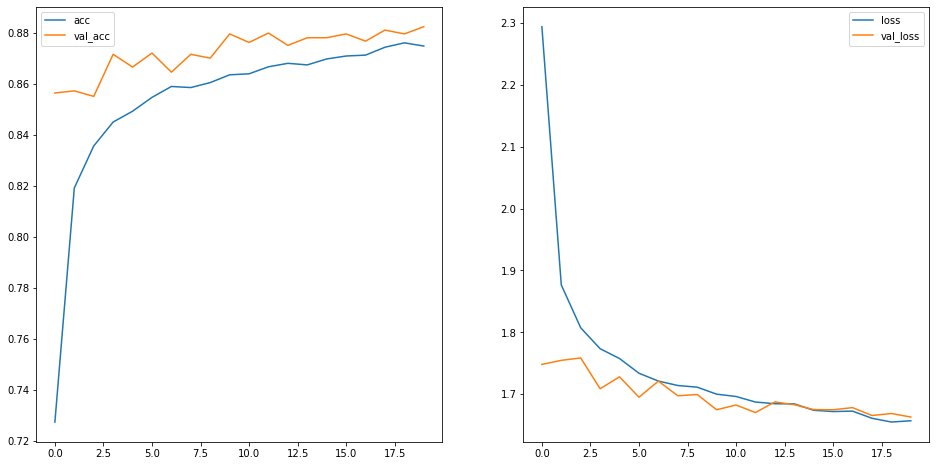

In [17]:
# 結果表示
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(history.history['acc'],label='acc')
plt.plot(history.history['val_acc'],label='val_acc')
plt.legend()
plt.subplot(122)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

# 推論

In [96]:
# predict用のmodel. ArcFaceLayerを除き,重みはloadして使用する
def create_predict_model(n_classes,s,m, model_file):
    base_model = create_feature_extraction_model()
    arcface_model = create_arcface_model(base_model,n_classes,m,s, model_file) #学習と同じlayer数
    predict_model = Model(arcface_model.get_layer(index=0).input, arcface_model.get_layer(index=-4).output)
    predict_model.summary()

    return predict_model

In [19]:
predict_model = Model(arcface_model.get_layer(index=0).input, arcface_model.get_layer(index=5).output)
predict_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


In [99]:
n_classes = 10
s = 30
m = 0.1
model_file = 'arcface_margin0.1_scale30_mnist_64features.hdf5'
predict_model = create_predict_model(n_classes,s,m,model_file)
#predict_model.summary()

load model : 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 64)                0         
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
__________________________________________________________

In [100]:
batch_size = 32
feature_pred = predict_model.predict(x_test,batch_size=batch_size,verbose=1)

10000/10000 [==============================] - 1s 126us/step


In [167]:
from sklearn.preprocessing import normalize
a = normalize(feature_pred,norm='l2')
np.linalg.norm(a[0],ord=2)

1.0

## 答え合わせする

In [177]:
from sklearn.preprocessing import normalize

def calc_confusion_matrix(pred,typical_vecs,y_test,num_classes):
    confusion_matrix = np.zeros((num_classes,num_classes))
    label_pred = []
    # l2正規化
    pred_normalize = normalize(pred,norm='l2')
    typical_vecs_normalize = normalize(typical_vecs,norm='l2')
    print(np.linalg.norm(pred_normalize[0],ord=2))
    print(np.linalg.norm(typical_vecs_normalize[0],ord=2))
    # 推論結果と各クラスの代表ベクトルとのコサイン類似度を計算してもっとも高い値のクラスとする
    init = True
    for i,pred_norm in enumerate(pred_normalize):
        #cos = np.dot(pred_norm,typical_vecs_normalize)
        cos = np.dot(typical_vecs_normalize,pred_norm)
        if init:
            print(pred_norm.shape)
            print(typical_vecs_normalize.shape)
            print(cos.shape)
            print(cos)
            print(np.argmax(y_test[i]))
            
            init = False
        cos_max = np.argmax(cos)
        label_pred.append(cos_max)
        correct_label = np.argmax(y_test[i])
        confusion_matrix[correct_label][cos_max] += 1
    return confusion_matrix,label_pred
    
# 答え合わせ
typical_vecs = np.array(arcface_model.get_layer(index=-2).get_weights())[0]
confusion_matrix,label_pred = calc_confusion_matrix(feature_pred,typical_vecs,y_test,num_classes)

1.0
0.99999994


ValueError: shapes (64,10) and (64,) not aligned: 10 (dim 1) != 64 (dim 0)

In [170]:
confusion_matrix[0]

array([810.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 170.])

# 検証

In [101]:
from sklearn.preprocessing import normalize
# l2正規化
feature_pred_normalize = normalize(feature_pred,norm='l2')
#feature_pred_normalize = np.l2_normalize(feature_pred)

## 特徴量が２次元（または３次元）の場合は可視化できるので可視化したい
２次元の場合は円周上にクラス毎に分かれてプロットされることを期待している  
３次元の場合は球上にクラス毎に分かれてプロットされることを期待している

W0717 19:19:21.714380 4540978624 legend.py:1282] No handles with labels found to put in legend.


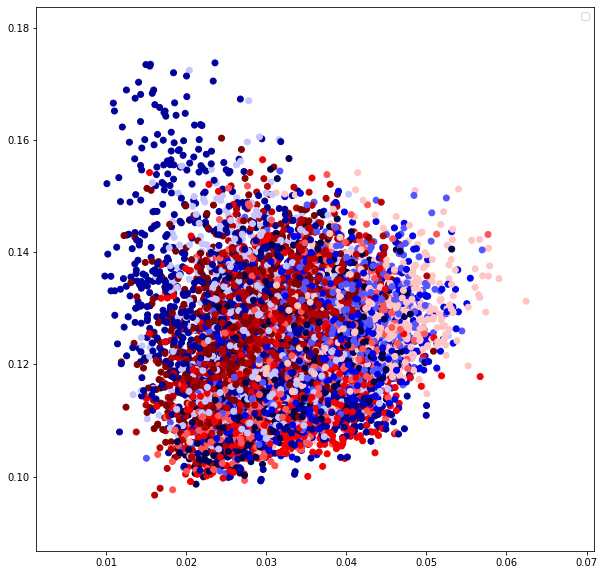

In [102]:
import matplotlib.cm as cm
# 可視化（６４次元なので意味なし）
y_test_label = np.argmax(y_test,axis=1)
plt.figure(figsize=(10,10))
plt.scatter(feature_pred_normalize[:,0],feature_pred_normalize[:,1],c=y_test_label,cmap=cm.seismic)
plt.legend()
plt.show()

## ６４次元のある単位ベクトルeとテストデータのコサイン類似度を調べる
所属するクラス毎にeとのコサイン類似度を調べてヒストグラムで表示

In [108]:

base_vec = np.array([1 if i == 0 else 0 for i in range(feature_pred.shape[1])])
y_test_label = np.argmax(y_test,axis=1)
cosines = []
for i,feature in enumerate(feature_pred_normalize):
    cos = np.dot(base_vec,feature)
    y = y_test_label[i]
    cosines.append([y,cos])
    
hist = []
num_classes = 10
for i in range(num_classes):
    targets = [v[1] for v in cosines if v[0] == i]
    hist.append(targets)

## クラスごとに結果表示

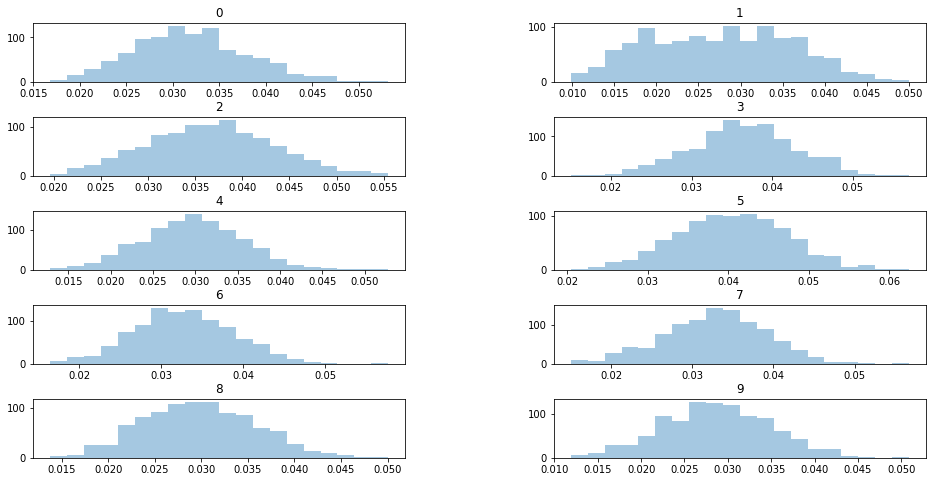

In [109]:
# クラス別にある単位ベクトルeとのコサイン類似度のヒストグラムを表示
import seaborn as sns
rows = num_classes / 2
cols = 2
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(num_classes):
    plt.subplot(rows,cols,i+1)
    sns.distplot(hist[i], kde=False, rug=False, bins=20) 
    plt.title(i)
plt.show()

## 全クラス重ねて表示
ほぼ0付近なので今回のベースモデルとはまったく近くないということになる

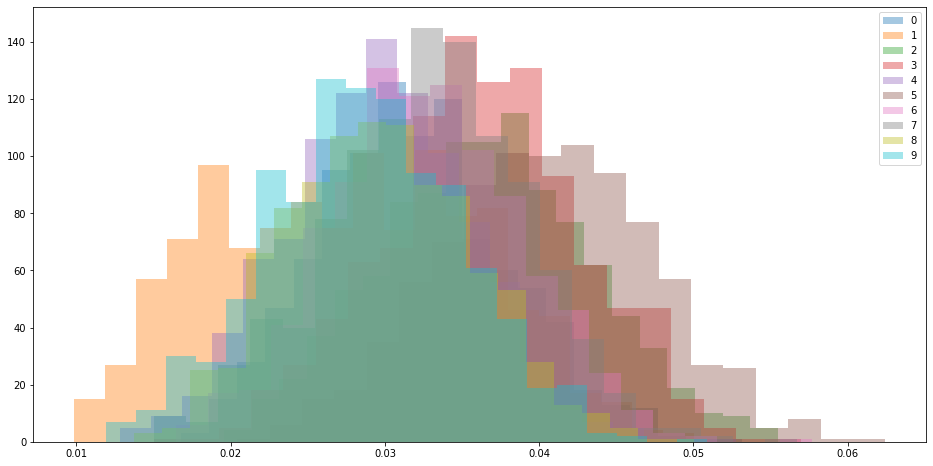

In [112]:
# 全クラス重ねて表示してみる
import seaborn as sns
plt.figure(figsize=(16,8))
for i in range(num_classes):
    sns.distplot(hist[i], kde=False, rug=False, bins=20,label=i) 
plt.legend()
plt.show()

## 各クラスの代表ベクトル間のコサイン類似度を計算してみる

In [106]:
# 各クラスの代表ベクトル間のコサイン類似度を計算してみる
from sklearn.preprocessing import normalize
typical_vecs = arcface_model.get_layer(name='arc_face_2').get_weights()
typical_vecs_normalize = normalize(typical_vecs[0],norm='l2')
num_classes = 10
result = []
for i in range(num_classes):
    vec_i_normalize = typical_vecs[0][:,i] / np.linalg.norm(typical_vecs[0][:,i],ord=2)
    vec_i = vec_i_normalize
    for j in range(num_classes):
        vec_j_normalize = typical_vecs[0][:,j] / np.linalg.norm(typical_vecs[0][:,j],ord=2)
        vec_j = vec_j_normalize
        result.append(np.dot(vec_i,vec_j))

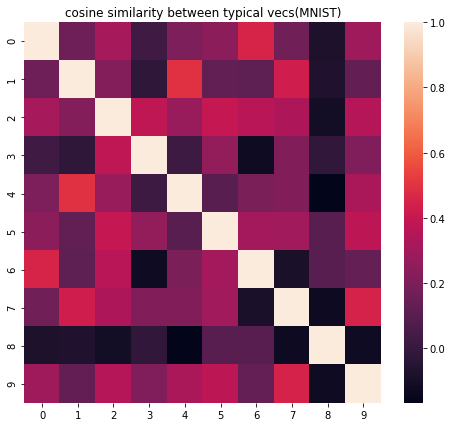

In [107]:
result_2d = np.reshape(np.array(result),(10,10))
plt.figure(figsize=(8,7))
plt.title('cosine similarity between typical vecs(MNIST)')
sns.heatmap(result_2d)

## knnグラフ構築してみる

In [127]:
def save_graph_to_csv(G,csv_file_path):
    with open(csv_file_path,'w') as f:
        array = G.toarray()
        for i in range(array.shape[0]):
            content = str(i)
            for connected in np.where(array[i] == 1)[0]:
                content += ',{}'.format(connected)
            content += '\n'
            f.write(content)

In [128]:
from sklearn.neighbors import kneighbors_graph
neighbors = 3
G = kneighbors_graph(feature_pred_normalize,neighbors)
save_graph_to_csv(G,'./graph_csv/arcface_knn3.csv')

## radius neighbors graph作ってみる

In [134]:
from sklearn.neighbors import radius_neighbors_graph
radius = 0.05
G = radius_neighbors_graph(feature_pred_normalize,radius)
save_graph_to_csv(G,'./graph_csv/arcface_rn05.csv')

In [79]:
a

array([[-4.48718667e-02,  3.46530154e-02,  4.38263873e-04,
         2.09045615e-02,  2.68077590e-02,  2.81384755e-02,
         5.81414625e-02,  2.38712728e-02,  1.91940948e-01,
         9.74307884e-04],
       [ 7.01393113e-02, -2.21004966e-03,  3.11677903e-02,
         4.47803847e-02,  3.23063023e-02,  1.73614956e-02,
         8.26858357e-02, -4.81745377e-02,  9.25216675e-02,
        -1.61906611e-02],
       [ 3.26312296e-02,  3.58645990e-02,  7.79849961e-02,
         2.32670512e-02,  4.65279780e-02,  8.12358875e-03,
         7.49872550e-02, -2.02019612e-04, -8.78689438e-02,
         2.92332731e-02],
       [-6.80876672e-02,  2.56690960e-02,  2.79030837e-02,
        -6.92851916e-02,  2.09887084e-02,  2.26131715e-02,
        -1.81773789e-02,  1.92562286e-02, -1.96780160e-01,
         4.54275357e-03],
       [-2.65677124e-02,  2.89787799e-02,  4.12378199e-02,
         1.25065967e-02,  2.70547830e-02,  2.76541524e-02,
         1.03067013e-03,  1.88774783e-02, -2.23423421e-01,
        -8.

In [80]:
typical_vecs[0][:,1]

array([ 0.11248352, -0.00717381,  0.11641632,  0.08332177,  0.09406498,
        0.3500513 ,  0.18473603,  0.2371431 ,  0.01691396,  0.16175246,
        0.26506093, -0.01558166,  0.13060915,  0.15687345,  0.05418136,
        0.06854122,  0.17639385,  0.12156195,  0.32471928,  0.03216977,
        0.1616397 ,  0.06445633,  0.15330054,  0.01944336, -0.16788961,
       -0.06298754, -0.42776388,  0.02208986,  0.1462258 , -0.15326376,
       -0.31113803,  0.1160781 ,  0.04807528, -0.47675833,  0.15158682,
        0.1526146 ,  0.1005783 , -0.071234  ,  0.16709723, -0.35525802,
        0.10206717,  0.13491549, -0.37069458, -0.19173631,  0.15209022,
       -0.37416786,  0.14133745, -0.34698123,  0.19170643, -0.27857196,
        0.07886507,  0.04375498, -0.09527376,  0.06652762,  0.18467912,
        0.07086195, -0.36906245,  0.09900179,  0.12088358,  0.13427748,
        0.01343187,  0.32500887,  0.17075105, -0.16131417], dtype=float32)